## Required Imports

First, we start by importing the required libraries. Matplotlib is used for plotting. sklearn is used for importing the MNIST dataset. A random seed of 5655 is used to ensure reproducibility.

In [1]:
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
%matplotlib inline

rng = np.random.default_rng(5655)

## Signatures of Base Classes

Here we define the backbone of the classes that will be inherited and expanded upon later. We define three class types - layer, activation and loss. We inherit them later and make them complete. 

In [2]:
class Layer(object):
	'''
	This class provides a signature for a layer. It can be used for any 
	type of layer
	'''
	def __init__(self, inp, out):
		pass

	def forward(self, x):
		pass

	def backward(self, error):
		pass

In [3]:
class Activation(object):
	'''
	This class provides a signature for a activation function. It can be used for any 
	type of activation function
	'''
	def __init__(self):
		pass

	def forward(self, x):
		pass

	def backward(self, x):
		pass

In [4]:
class Loss(object):
	'''
	This class provides a signature for a loss function. It can be used for any 
	type of loss function
	'''
	def __init__(self):
		pass

	def forward(self, x):
		pass

	def backward(self, x):
		pass

if __name__ == '__main__':
	pass

## Linear Layer Class

In [5]:
class Linear(Layer):
    '''
    This class implements a linear layer.
    A linear layer is a fully connected or a dense layer. This class does not
    take in an activation. 
    '''
    def __init__(self, inp, out):
        '''
        Initializes a layer object
        Input - 
            inp: the size of the input
        Output -
            out: the size of the output
        '''
        self.weights = rng.uniform(-1./np.sqrt(out), 1./np.sqrt(out), (out, inp))
        self.bias = rng.uniform(-1./np.sqrt(out), 1./np.sqrt(out), (out, 1))

    def forward(self, x):
        '''
        Implements the forward pass of the linear layer
        It is simply matrix multiplication: z = Wx + b
        Input - 
            x: input batch: shape: (n_features, batch_size), numpy array of floats
        Output -
            self.logits: output batch: shape: (out_features, batch_size), numpy array of floats
        '''
        # x = np.vstack([x, np.array([1.]*x.shape[1])])
        self.inputs = x.copy()
        self.logits = self.weights @ x + self.bias
        return self.logits

    def backward(self, error):
        '''
        Implements the backward pass through the layer
        Input -
            error: the numpy array of gradients returned from the previous layer
        Output -
            self.d_weights: the gradient of the loss function with respect to the layer weights, numpy array of floats
            self.d_bias: the gradient of the loss function with respect to the layer bias, numpy array of floats
        '''
        self.d_act = error
        # print('e=',error.shape)
        # print('y_prev=',self.inputs.shape)
        self.d_weights = error @ self.inputs.T/self.inputs.shape[1]
        self.d_bias = error.mean(axis=1, keepdims=True)
        self.d_act = self.weights.T @ self.d_act
        # print('d_act=', self.d_act.shape)
        return self.d_weights, self.d_bias

    def reset(self):
        '''
        Empties the cache of the layer - the stored inputs, logits, derivative with respect to activations
        and derivative with respect to weights
        '''
        self.inputs = None
        self.logits = None
        self.d_act = None
        self.d_weights = None

    def set_weights(self, w, b):
        '''
        Given the weights and biases of a layer, it sets the weights and bias of the layer
        Inputs - 
            w: a numpy array of floats 
            b: a numpy array of floats
        Outputs -
            None
        '''
        # print('w=', w.shape)
        # print('weights=', self.weights.shape)
        assert self.weights.shape == w.shape
        assert self.bias.shape == b.shape
        self.weights = w
        self.bias = b
        return

## Sigmoid Activation

Here we implement the sigmoid activation, which is typically used for binary classification.

In [6]:
class Sigmoid(Activation):
    ''' Implements the Sigmoid activation function'''
    def __init__(self):
        pass

    def forward(self, x):
        y = 1. + np.exp(-1.*x)
        return 1./y

    def backward(self, x, act):
        return act*(1 - act)*x

## Tanh Activation

Here we implement the tanh activation. It is used in the hidden layers of the network.

In [7]:
class Tanh(Activation):
    ''' Implements the Tanh activation function'''
    def __init__(self):
        pass

    def forward(self, x):
        return np.tanh(x)

    def backward(self, x, act):
        return (1 - act**2)*x 

## Softmax Activation

Here we implement the softmax classification which is used in multi class classification problems.

In [8]:
class Softmax(Activation):
    ''' Implements the Softmax activation function'''
    def __init__(self):
        pass

    def forward(self, x):
        # x = x - np.max(x, axis=0, keepdims=True)
        y = np.exp(x)
        return y/np.sum(y, axis=0, keepdims=True)

    def backward(self, x, act):
        assert x.shape[1] == act.shape[1]
        # print('x=',x.shape)
        s = np.zeros(x.shape)
        for i in range(x.shape[1]):
            mat = np.diag(act[:, i]) - np.outer(act[:, i], act[:, i])
            # print('mat=',mat.shape)
            vec = x[:, i].reshape((-1, 1))
            # print('vec=',vec.shape)
            s[:, i] = (mat @ vec).reshape(-1)
            # print('s=',s.shape)
        # s = s/x.shape[1]
        return s

## Negative Log Likelihood Loss

Here we implement the negative log likelihood loss function which is used for multi class classification.

In [9]:
class NegativeLogLikelihood(Loss):
    ''' Implements the Negative Log Likelihood Loss function'''
    def __init__(self):
        pass

    def forward(self, x, y):
        return -1.*np.mean(np.diag(y.T @ np.log(x)))

    def backward(self, x, y):
        return -1.*y/(x + 1e-8)

## Binary Cross Entropy Loss

Here we implement the binary cross entropy loss function which is used for binary classification.

In [10]:
class BinaryCrossEntropy(Loss):
    ''' Implements the Binary Cross Entropy Loss function'''
    def __init__(self):
        pass

    def forward(self, x, y):
        # print(y.shape)
        # print(x.shape)
        q = y.T @ np.log(x) + (1-y).T @ np.log(1-x)
        return -1.*(np.mean(np.diag(q)))

    def backward(self, x, y):
        q = y/(x + 1e-8) + (1 - y)/(1 - x + 1e-8)
        return -1.*q

## The Sequential Class

This class ties together the layers and the activation functions and implements the forward and backward passes through them.

In [11]:
class Sequential(Layer, Activation):
    def __init__(self, layers, activations):
        self.layers = layers
        self.activations = activations
        self.layer_grads = []
        self.zs = []
        self.acts = []

    def forward(self, x):
        '''
        Given an input, this method implements the forward pass through the network
        Input -
            x: a numpy array of floats of shape (n_featues, batch_size)
        Output -
            x: a numpy array of floats of shape (out_features, batch_size)
        '''
        self.zs = []
        self.acts = []
        for l, a in zip(self.layers, self.activations):
            x1 = l.forward(x)
            self.zs.append(x1)
            x = a.forward(x1)
            self.acts.append(x)
        return x

    def backward(self, x):
        '''Implements the backward pass through the neural network
        Input -
            x: a numpy array of floats - the gradient of the loss with respect to the outputs of the network
        Output -
            self.layer_grads: a list of tuples (derivative wrt weights, derivative wrt biases) - one for each
            layer of the neural network
        '''
        self.layer_grads = []
        i = 0
        for a, l, ahat in zip(reversed(self.activations), reversed(self.layers), reversed(self.acts)):
            if i == 0:
                # print('x=',x.shape)
                # print('ahat=',ahat.shape)
                d = a.backward(x, ahat)
                # print('d=',d.shape)
            else:
                # print('ahat=',ahat.shape)
                # print('d=', d.shape)
                d = a.backward(d, ahat)
                # print('d=',d.shape)
            d, b = l.backward(d)
            # print('d=',d.shape)
            self.layer_grads.append((d, b))
            d = l.d_act
            # print('d=', d.shape)
            i = i + 1
        self.layer_grads = self.layer_grads[::-1]
        # print(len(self.layer_grads))
        return self.layer_grads

## The Neural Network Class

In this class, we implement a fully connected neural network.

In [12]:
class NeuralNetwork(Sequential):
    '''
    Implements the fully connected Neural Network Class
    '''
    def __init__(self, layer_sizes, activations):
        '''
        Initializes a neural network object
        Inputs -
            layer_sizes: a list of layer sizes [input size, hidden 1 size, hidden 2 size, ..., output size]
            activations: a list of activation function objects
        '''
        self.input_sizes = layer_sizes[:-1]
        self.output_sizes = layer_sizes[1:]
        layers = [Linear(i, j) for i, j in zip(self.input_sizes, self.output_sizes)]
        self.model = Sequential(layers, activations)

    def forward(self, x):
        '''
        Given an input, this method implements the forward pass through the network
        Input -
            x: a numpy array of floats of shape (n_featues, batch_size)
        Output -
            self.model.forward(x): a numpy array of floats of shape (out_features, batch_size)
        '''
        return self.model.forward(x)

    def backward(self, x):
        '''Implements the backward pass through the neural network
        Input -
            x: a numpy array of floats - the gradient of the loss with respect to the outputs of the network
        Output -
            self.layer_grads: a list of tuples (derivative wrt weights, derivative wrt biases) - one for each
            layer of the neural network
        '''
        return self.model.backward(x)

    def apply_grads(self, x, lr):
        ''' 
        Changes the weights of the neural network layers
        Input -
            x: a numpy array of floats - the gradient of the loss with respect to the outputs of the network
            lr: a learning rate parameter
        Output -
            None
        '''
        grads = self.backward(x)
        assert len(grads) == len(self.model.layers)
        for l, (gw, gb) in zip(self.model.layers, grads):
            # print(l.weights.shape)
            # print(g.shape)
            weights = l.weights - lr*gw
            biases = l.bias - lr*gb
            l.set_weights(weights, biases)
        return 

    def save(self, filepath):
        '''Saves the model weights and other details to the given filepath'''
        for l in self.model.layers:
            l.reset()
        self.acts = []
        self.layer_grads = []
        save_dict = {'layer_sizes': [self.input_sizes[0]]+self.output_sizes,
                     'activations': self.model.activations,
                     'weights': [l.weights for l in self.model.layers],
                     'biases': [l.bias for l in self.model.layers]}
        with open(filepath, 'wb') as f:
            pickle.dump(save_dict, f)
        f.close()
        return

    def load(self, filepath):
        '''Loads a saved model from the provided filepath'''
        with open(filepath, 'rb') as f:
            w_dict = pickle.load(f)
        f.close()
        self.acts = []
        self.layer_grads = []
        self.zs = []
        # print(w_dict)
        assert len(self.model.activations) == len(w_dict['activations'])
        assert self.input_sizes == w_dict['layer_sizes'][:-1]
        assert self.output_sizes == w_dict['layer_sizes'][1:]
        for i, l in enumerate(self.model.layers):
            assert l.weights.shape == w_dict['weights'][i].shape
            assert l.bias.shape == w_dict['biases'][i].shape
            l.set_weights(w_dict['weights'][i], w_dict['biases'][i])
        return

## Categorical Labels to One Hot

In order to perform classification, the categorical labels need to be converted to one hot. This function is used for that purpose.

In [13]:
def to_categorical(id_vec, num_classes=10):
    '''Converts a list of labels to one hot encoded vectors
    Inputs -
        id_vec: a numpy array of labels to be one hot encoded
        num_classes: the size of each one hot encoded vector
    Outputs - 
        labels: the one hot encoded outputs
    '''
    labels = np.zeros((num_classes, id_vec.shape[0]))
    for i in range(id_vec.shape[0]):
        id_ = id_vec[i]
        assert id_ <= num_classes-1
        labels[id_, i] = 1
    return labels

## Function to train the neural network

In [14]:
def train(model, train_data, train_labels, val_data, val_labels, criterion, lr, epochs, batch_size=32, print_every=10, num_classes=2):
    '''
    Trains a neural network model
    Inputs:
        model - a neural network object to train
        train_data - a numpy array of input training features
        train_labels - a numpy array of input training labels
        val_data - a numpy array of input validation features
        val_labels - a numpy array of input validation labels
        criterion - a loss function object
        lr - learning rate
        epochs - number of training epochs
        batch_size - number of instances to train on each time
        print_every - gap at which the log has to be printed to the terminal
        num_classes - number of classes in the input data
    Outputs:
        train_losses - a list of losses on the training data
        val_losses - a list of losses on the validation data
    '''
    if isinstance(criterion, BinaryCrossEntropy):
        assert train_data.shape[1] == train_labels.shape[0]
        assert val_data.shape[1] == val_labels.shape[0]
        train_labels = train_labels.reshape((1, -1))
        val_labels = val_labels.reshape((1, -1))
    else:
        train_labels = to_categorical(train_labels, num_classes=num_classes)
        val_labels = to_categorical(val_labels, num_classes=num_classes)
        assert train_data.shape[1] == train_labels.shape[1]
        assert val_data.shape[1] == val_labels.shape[1]

    if train_data.shape[1]%batch_size == 0:
        n_batches = train_data.shape[1]//batch_size
    else:
        n_batches = train_data.shape[1]//batch_size + 1
    # criterion = NegativeLogLikelihood()
    train_losses = []
    val_losses = []
    stop_counter = 0
    for i in range(epochs):
        l = 0
        start = time.time()
        for j in range(n_batches):
            x = train_data[:, j*batch_size:(j+1)*batch_size]
            y = train_labels[:, j*batch_size:(j+1)*batch_size]
            yhat = model.forward(x)
            loss = criterion.forward(yhat, y)
            l += loss/x.shape[1]
            l_grad = criterion.backward(yhat, y)
            model.apply_grads(l_grad, lr)
        t = time.time() - start
        epoch_loss = l/n_batches

        val_targets = model.forward(val_data)
        val_loss = criterion.forward(val_targets, val_labels)

        if (i+1)%print_every == 0:
            print("Epoch {}, time {:.4f} seconds, training loss {:.4f}, validation loss {:.4f}".format(i+1, t, epoch_loss, val_loss))
            # lr = lr/5.0
        train_losses.append(epoch_loss)

        if i >= 1 and val_loss >= val_losses[-1]:
            stop_counter += 1
        else:
            stop_counter = 0

        val_losses.append(val_loss)

        if stop_counter >= 5:
            print("No improvement in validation loss in the last 5 epochs, so stopping training")
            break
    return train_losses, val_losses

## Function to test the neural network

In [15]:
def test(model, data, labels):
    '''
    Tests a pretrained neural network
    Inputs -
        model - a pretrained neural network object
        data - the test set
        labels - the test labels
    Outputs -
        accuracy - the accuracy of classification achieved on the test data
    '''
    assert data.shape[1] == labels.shape[0]
    n_correct = 0
    for i in range(data.shape[1]):
        x = data[:, i].reshape((-1, 1))
        yhat = model.forward(x)
        ind = np.argmax(yhat, axis=0).item()
        if ind == labels[i]:
            n_correct = n_correct + 1
    accuracy = n_correct/labels.shape[0]
    return accuracy

if __name__ == '__main__':
    pass

## Testing the Neural Network on the XOR Problem

In this problem, the training data consists of four points and two classes. 

1. \[0, 0\] and \[1., 1.\] belong to class 0
2. \[1., 0\] and \[0, 1.\] belong to class 1.

As we can easily see from the training data, it is not linearly separable. To keep things simple, we use the same data for validation and testing.

To verify that our library is working fine, we first create a neural network with a single hidden layer of 10 neurons and an output layer of 2 neurons. The input layer has 2 neurons. It is trained for 100 epochs with a learning rate of 0.1, and the weights are saved to a file. Early stopping is introduced to check if the validation loss does not improve over the last 5 epochs then the training is stopped. 

Later the file is loaded and the model is tested on the same data. It is expected that the code yields no errors during training and testing, then its fine. Also, the losses are plotted after training. 

Epoch 100, time 0.0002 seconds, training loss 0.1787, validation loss 0.7149
Epoch 200, time 0.0002 seconds, training loss 0.1766, validation loss 0.7063
Epoch 300, time 0.0002 seconds, training loss 0.1754, validation loss 0.7016
Epoch 400, time 0.0005 seconds, training loss 0.1747, validation loss 0.6988
Epoch 500, time 0.0003 seconds, training loss 0.1742, validation loss 0.6968
Epoch 600, time 0.0002 seconds, training loss 0.1738, validation loss 0.6953
Epoch 700, time 0.0002 seconds, training loss 0.1735, validation loss 0.6940
Epoch 800, time 0.0002 seconds, training loss 0.1732, validation loss 0.6928
Epoch 900, time 0.0002 seconds, training loss 0.1729, validation loss 0.6915
Epoch 1000, time 0.0002 seconds, training loss 0.1725, validation loss 0.6901
Accuracy after training is 0.5000


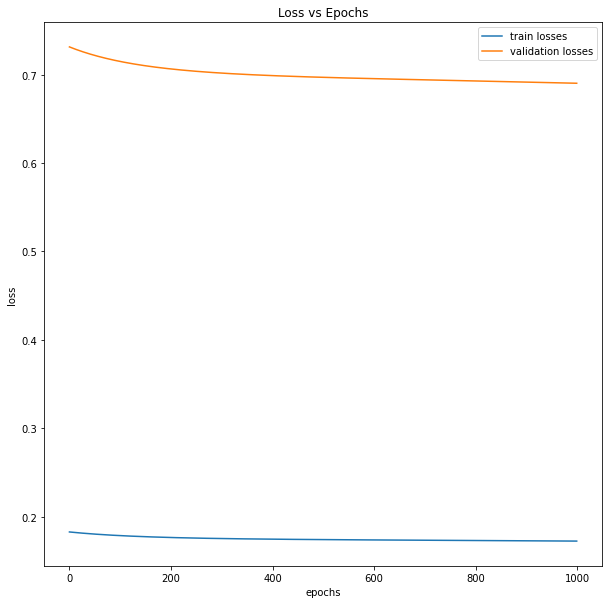

In [16]:
layer_sizes = [2, 10, 2]
activations = [Tanh(), Softmax()]
model = NeuralNetwork(layer_sizes, activations)

train_data = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
train_labels = np.array([0, 1, 1, 0])
# train_labels = to_categorical(train_labels, num_classes=2)

val_data = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
val_labels = np.array([0, 1, 1, 0])
# val_labels = to_categorical(val_labels, num_classes=2)

test_data = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
test_labels = np.array([0, 1, 1, 0])

lr = 0.01
epochs = 1000
criterion = NegativeLogLikelihood()
train_losses, val_losses = train(model, train_data, train_labels, val_data, val_labels, 
                                 criterion, lr, epochs, print_every=100, num_classes=2)
model.save('./weights.w')
model.load('./weights.w')
accuracy = test(model, test_data, test_labels)
print("Accuracy after training is {:.4f}".format(accuracy))

plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs')
plt.show()

It was seen that the code ran successfully. Although the loss did not decrease after a point. The reason could be less number of data or too small gradients in the hidden layer due to tanh activation function. From the accuracy it seems that two of the points is misclassified.

## Classifying handwritten digits on MNIST data with Neural Networks

In this section, we experiment with the MNIST dataset. Out of the 70000 samples, 60000 are used for training, 10000 are used for testing. Out of the 60000 training samples, 6000 are used for validation only, so 54000 are left for training. Each image is reshaped into a 784x1 dimensional vector for training. Moreover, the uint8 intensity values are scaled to the range 0 to 1 by dividing by 255 before using for training.

The MNIST dataset is available with the sklearn package using the fetch\_openmml functionality.

In this experiment, we train 3 neural networks with different number of hidden neurons (5, 10, 20 respectively) each with 1 hidden layer, and an output layer of size 10. Hidden activations are all tanh. All models are trained for 200 epochs with a learning rate of 0.01 and batch size of 64. The learning curves, and the accuracies of each model are reported. The best model architecture from this experiment is selected for further experiments in the sections below. The weights of the best model are saved to 'MNIST.w' file.

### Loading and Preparing the MNSIT dataset.

In [17]:
samples, targets = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
samples = samples.T/255.0
train_x = samples[:, :54000]
val_x = samples[:, 54000:60000]
test_x = samples[:, 60000:70000]
train_y = targets[:54000]
train_y = np.array([int(k) for k in train_y])
val_y = targets[54000:60000]
val_y = np.array([int(k) for k in val_y])
test_y = targets[60000:70000]
test_y = np.array([int(k) for k in test_y])
print('train data :', train_x.shape)
print('train labels :', train_y.shape)
print('val data :', val_x.shape)
print('val labels :', val_y.shape)
print('test data :', test_x.shape)
print('test labels :', test_y.shape)

train data : (784, 54000)
train labels : (54000,)
val data : (784, 6000)
val labels : (6000,)
test data : (784, 10000)
test labels : (10000,)


### Train first net - 5 hidden neurons

Epoch 50, time 1.5159 seconds, training loss 0.0069, validation loss 0.3797
Epoch 100, time 1.4899 seconds, training loss 0.0058, validation loss 0.3332
Epoch 150, time 1.6411 seconds, training loss 0.0055, validation loss 0.3165
Epoch 200, time 1.6039 seconds, training loss 0.0053, validation loss 0.3071
Accuracy after training is 0.8954


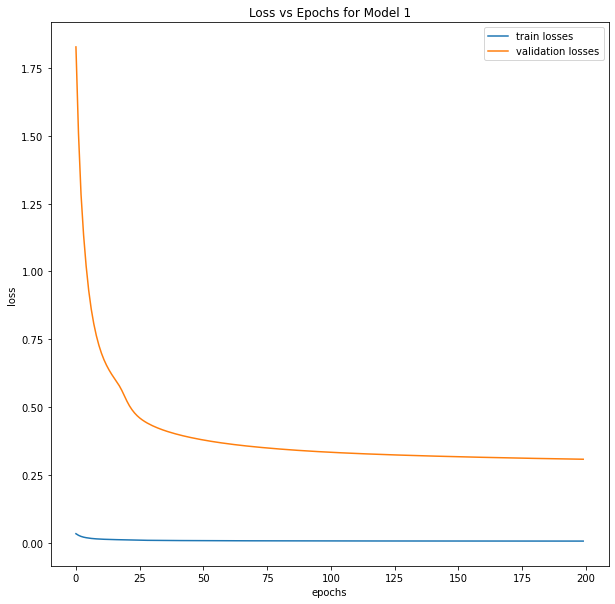

In [18]:
layer_sizes = [784, 5, 10]
activations = [Tanh(), Softmax()]
model_1 = NeuralNetwork(layer_sizes, activations)
lr = 0.01
epochs = 200
criterion = NegativeLogLikelihood()
train_losses, val_losses = train(model_1, train_x, train_y, val_x, val_y, 
                                 criterion, lr, epochs, print_every=50, batch_size=64, num_classes=10)
accuracy = test(model_1, test_x, test_y)
print("Accuracy after training is {:.4f}".format(accuracy))

plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs for Model 1')
plt.show()

### Train second net - 10 hidden neurons

Epoch 50, time 3.5030 seconds, training loss 0.0044, validation loss 0.2485
Epoch 100, time 2.9302 seconds, training loss 0.0037, validation loss 0.2176
Epoch 150, time 2.9379 seconds, training loss 0.0033, validation loss 0.2030
Epoch 200, time 2.9863 seconds, training loss 0.0031, validation loss 0.1942
Accuracy after training is 0.9311


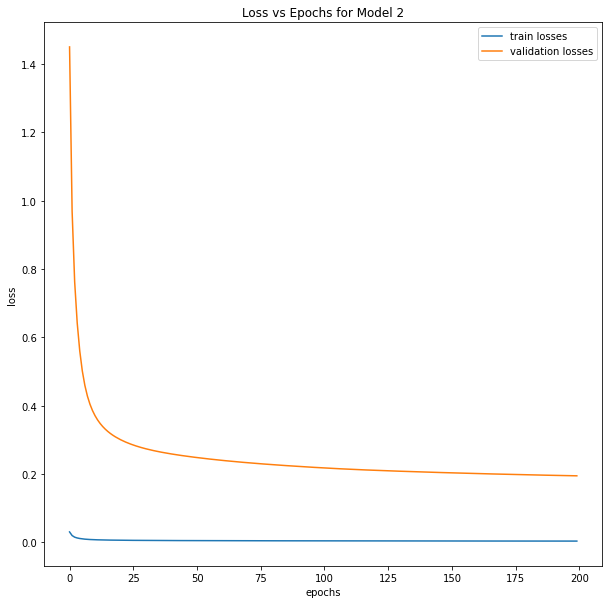

In [19]:
layer_sizes = [784, 10, 10]
activations = [Tanh(), Softmax()]
model_2 = NeuralNetwork(layer_sizes, activations)
lr = 0.01
epochs = 200
criterion = NegativeLogLikelihood()
train_losses, val_losses = train(model_2, train_x, train_y, val_x, val_y, 
                                 criterion, lr, epochs, print_every=50, batch_size=64, num_classes=10)
accuracy = test(model_2, test_x, test_y)
print("Accuracy after training is {:.4f}".format(accuracy))

plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs for Model 2')
plt.show()

### Train third net - 20 hidden neurons

Epoch 50, time 3.2430 seconds, training loss 0.0029, validation loss 0.1612
Epoch 100, time 3.1230 seconds, training loss 0.0022, validation loss 0.1374
Epoch 150, time 3.4785 seconds, training loss 0.0019, validation loss 0.1261
Epoch 200, time 3.6604 seconds, training loss 0.0016, validation loss 0.1207
Accuracy after training is 0.9536


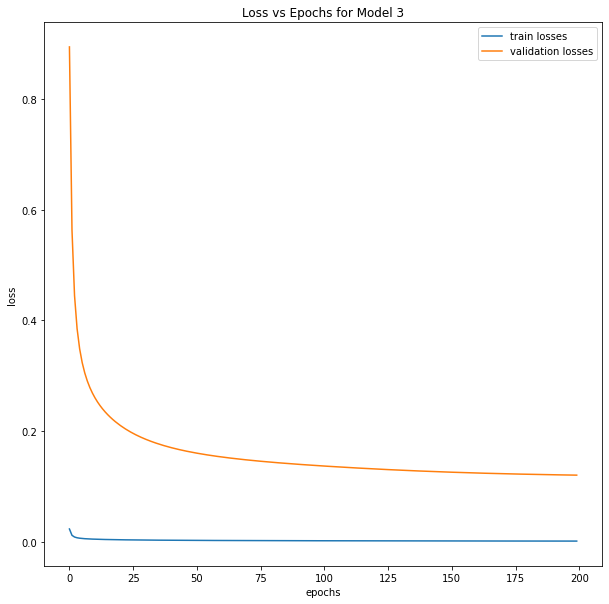

In [20]:
layer_sizes = [784, 20, 10]
activations = [Tanh(), Softmax()]
model_3 = NeuralNetwork(layer_sizes, activations)
lr = 0.01
epochs = 200
criterion = NegativeLogLikelihood()
train_losses, val_losses = train(model_3, train_x, train_y, val_x, val_y, 
                                 criterion, lr, epochs, print_every=50, batch_size=64, num_classes=10)
accuracy = test(model_3, test_x, test_y)
print("Accuracy after training is {:.4f}".format(accuracy))

plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs for Model 3')
plt.show()

So, the model with 20 hidden neurons performs the best by achieving an accuracy of 95.36\% on the test set. It is saved to 'MNIST.w' file. This file can be loaded and the accuracy on the test set can be rechecked.

In [21]:
model_3.save('MNIST.w')

In [22]:
layer_sizes = [784, 20, 10]
activations = [Tanh(), Softmax()]
model = NeuralNetwork(layer_sizes, activations)
model.load('MNIST.w')
accuracy = test(model, test_x, test_y)
print("Accuracy after training is {:.4f}".format(accuracy))

Accuracy after training is 0.9536


In the following experiments, the same model architecture as the one saved above is used.

## Further Experiments

In this section, further experiments are performed to examine the properties of neural networks and their training.

### Effect of zero initialization of weights and biases

In this experiment, we initialize all model weights to zeros and see the training performance over 200 epochs. The learning rate is set to 0.01 and batch size to 64.

No improvement in validation loss in the last 5 epochs, so stopping training
Accuracy after training is 0.1135


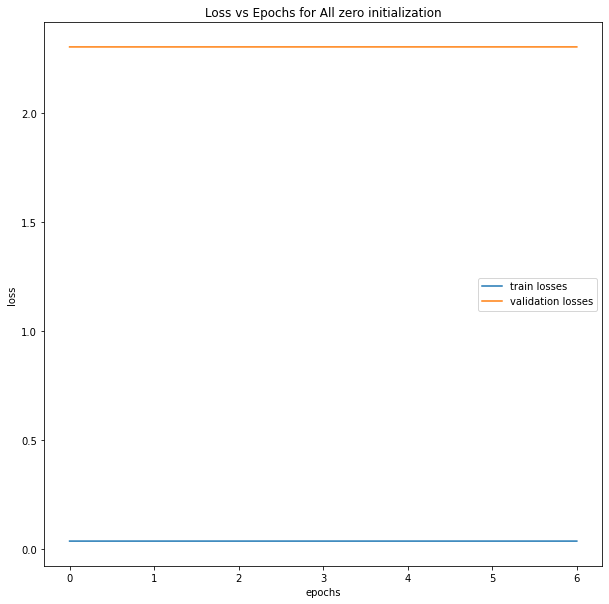

In [24]:
layer_sizes = [784, 20, 10]
activations = [Tanh(), Softmax()]
model = NeuralNetwork(layer_sizes, activations)
for l in model.model.layers:
    l.weights = np.zeros(l.weights.shape)
    l.bias = np.zeros(l.bias.shape)
lr = 0.01
epochs = 200
criterion = NegativeLogLikelihood()
train_losses, val_losses = train(model, train_x, train_y, val_x, val_y, 
                                 criterion, lr, epochs, print_every=50, batch_size=64, num_classes=10)
accuracy = test(model, test_x, test_y)
print("Accuracy after training is {:.4f}".format(accuracy))

plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs for All zero initialization')
plt.show()

If all the weights are initialized to zeros, the derivatives will remain same for every weight. As a result, neurons will learn same features in each iterations. This problem is known as network failing to break symmetry. And not only zero, any constant initialization will produce a poor result. This can be seen by the fact that the loss stays the same, the gradients are all zeros due to multiplication with weights, and hence there is no learning.

### Effect of random weight and bias initialization between -10 and 10

In this experiment, we initialize all model weights randomly between -10 and 10 and see the training performance over 200 epochs. The learning rate is set to 0.01 and batch size to 64.

Epoch 50, time 4.0014 seconds, training loss 0.2945, validation loss 18.0501
Epoch 100, time 3.9582 seconds, training loss 0.1438, validation loss 8.4575
Epoch 150, time 3.0087 seconds, training loss 0.0831, validation loss 4.8116
Epoch 200, time 3.0432 seconds, training loss 0.0216, validation loss 1.1984
Accuracy after training is 0.6726


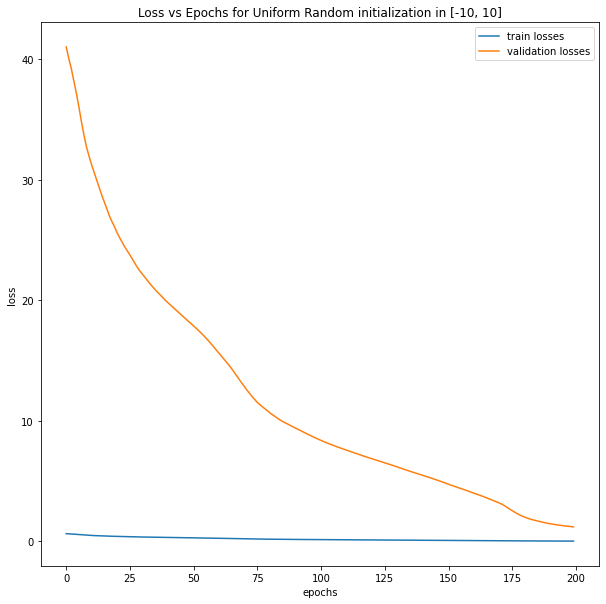

In [25]:
layer_sizes = [784, 20, 10]
activations = [Tanh(), Softmax()]
model = NeuralNetwork(layer_sizes, activations)
for l in model.model.layers:
    l.weights = np.random.uniform(-10, 10, l.weights.shape)
    l.bias = np.random.uniform(-10, 10, l.bias.shape)
lr = 0.01
epochs = 200
criterion = NegativeLogLikelihood()
train_losses, val_losses = train(model, train_x, train_y, val_x, val_y, 
                                 criterion, lr, epochs, print_every=50, batch_size=64, num_classes=10)
accuracy = test(model, test_x, test_y)
print("Accuracy after training is {:.4f}".format(accuracy))

plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs for Uniform Random initialization in [-10, 10]')
plt.show()

Random initialization makes performance better than zero or constant initialization but it also makes the convergence slower. Sampling from an interval \[-10, 10\] means that numbers such as 9.5 can be sampled. Large numbers and high variance due to scaling lead to increased convergence time.

### Effect of training with different Learning Rates - 1.0 and 0.001

All other parameters are kept the same.

#### Learning rate of 1.0

Epoch 50, time 3.0165 seconds, training loss 0.0012, validation loss 0.2255
Epoch 100, time 3.6448 seconds, training loss 0.0009, validation loss 0.2519
Epoch 150, time 2.9911 seconds, training loss 0.0008, validation loss 0.2887
Epoch 200, time 3.0469 seconds, training loss 0.0006, validation loss 0.2966
Accuracy after training is 0.9400


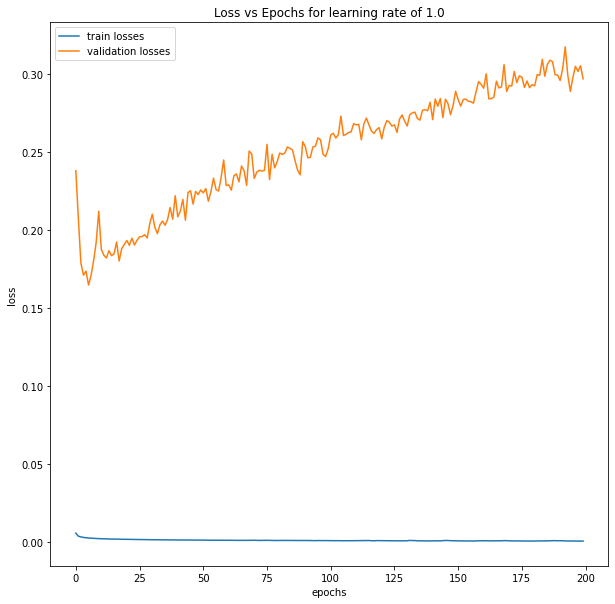

In [26]:
layer_sizes = [784, 20, 10]
activations = [Tanh(), Softmax()]
model = NeuralNetwork(layer_sizes, activations)

lr = 1.0
epochs = 200
criterion = NegativeLogLikelihood()
train_losses, val_losses = train(model, train_x, train_y, val_x, val_y, 
                                 criterion, lr, epochs, print_every=50, batch_size=64, num_classes=10)
accuracy = test(model, test_x, test_y)
print("Accuracy after training is {:.4f}".format(accuracy))

plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs for learning rate of 1.0')
plt.show()

With a larger learning rate such as 1.0, even though the performance is better than random initialization of weights and a smaller learning rate, it is seen that the training loss increases over time. This can be expected with larger learning rates as they lead to divergence of the training. This is where early stopping comes in and the training is halted when the validation epoch does not improve for 5 consecutive epochs.

#### Learning rate of 0.001

Epoch 50, time 3.0202 seconds, training loss 0.0066, validation loss 0.3646
Epoch 100, time 3.0290 seconds, training loss 0.0052, validation loss 0.2826
Epoch 150, time 2.9950 seconds, training loss 0.0045, validation loss 0.2492
Epoch 200, time 3.0492 seconds, training loss 0.0041, validation loss 0.2291
Accuracy after training is 0.9253


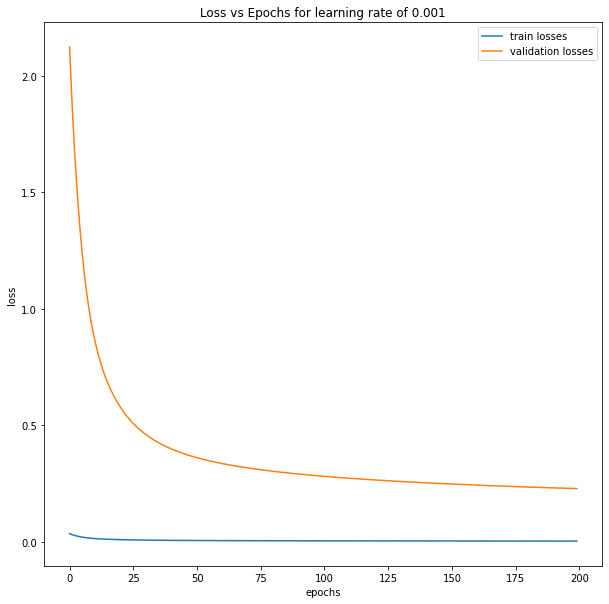

In [27]:
layer_sizes = [784, 20, 10]
activations = [Tanh(), Softmax()]
model = NeuralNetwork(layer_sizes, activations)

lr = 0.001
epochs = 200
criterion = NegativeLogLikelihood()
train_losses, val_losses = train(model, train_x, train_y, val_x, val_y, 
                                 criterion, lr, epochs, print_every=50, batch_size=64, num_classes=10)
accuracy = test(model, test_x, test_y)
print("Accuracy after training is {:.4f}".format(accuracy))

plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs for learning rate of 0.001')
plt.show()

With a smaller learning rate, the model takes very small steps towards the optima, and hence the convergence is slower. Unlike the large learning rate case, it is seen that the loss keeps on decreasing continuously. However, the performance is slightly lower than the higher learning rate case. With learning rate of 0.001, the accuracy is 92.53\% and with learning rate 1.0, the accuracy is 94.00\%. However, if the number of training epochs is increased in the first case, then a better performance than the higher learning rate case can be expected.

## Observations and Conclusions

1. The best architecture that was found from the experiments with the three models is the one with 20 hidden neurons.
2. If all the weights are initialized to zeros, the derivatives will remain same for every weight. As a result, neurons will learn same features in each iterations. This problem is known as network failing to break symmetry. And not only zero, any constant initialization will produce a poor result. This can be seen by the fact that the loss stays the same, the gradients are all zeros due to multiplication with weights, and hence there is no learning.
3. Random initialization makes performance better than zero or constant initialization but it also makes the convergence slower. Sampling from an interval \[-10, 10\] means that numbers such as 9.5 can be sampled. Large numbers and high variance due to scaling lead to increased convergence time.
4. With a larger learning rate such as 1.0, even though the performance is better than random initialization of weights and a smaller learning rate, it is seen that the training loss increases over time. This can be expected with larger learning rates as they lead to divergence of the training. This is where early stopping comes in and the training is halted when the validation epoch does not improve for 5 consecutive epochs.
5. With a smaller learning rate, the model takes very small steps towards the optima, and hence the convergence is slower. Unlike the large learning rate case, it is seen that the loss keeps on decreasing continuously. However, the performance is slightly lower than the higher learning rate case. With learning rate of 0.001, the accuracy is 92.53\% and with learning rate 1.0, the accuracy is 94.00\%. However, if the number of training epochs is increased in the first case, then a better performance than the higher learning rate case can be expected.